In [62]:
from pathlib import Path
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters

In [12]:
DATA_PATH = Path("../data")
SEED = sum(map(ord, "Statistical Rethinking, Lecture 9"))
rng = np.random.default_rng(seed=SEED)

# Data

In [9]:
df_ucb = (
    pd.read_csv(DATA_PATH / "UCBAdmit.csv", sep=";")
    .rename(columns={"applicant.gender": "gender"})
)

In [10]:
df_ucb.head()

,dept,gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


# Generative Model 

In [84]:
N = 1000 # Number of applicants

## No Direct Discrimination

In [76]:
G_ind = rng.binomial(1, p=0.5, size=N)  # Gender of applicants (0 are men for instance)
D_ind = rng.binomial(1, p=0.3 + 0.5*G)  # Women are more likely to apply to department 1
# Acceptance rate for the two departments
# No direct gender effects (the two columns are the same)
# Department 0 (first row) has higher acceptance rate
acc_rate_ind = np.array([[0.3, 0.3], [0.1, 0.1]])  

In [77]:
acc_rate_ind

array([[0.3, 0.3],
       [0.1, 0.1]])

In [78]:
# Simulated acceptance
A_ind = rng.binomial(1, p=acc_rate[D_ind, G_ind])

In [79]:
A_ind[G_ind==0].mean()

0.17307692307692307

In [80]:
A_ind[G_ind==1].mean()

0.12083333333333333

## With Direct Discrimination 

In [81]:
G_dir = rng.binomial(1, p=0.5, size=N)  # Gender of applicants (0 are men for instance)
D_dir = rng.binomial(1, p=0.3 + 0.5*G)  # Women are more likely to apply to department 1
# Acceptance rate for the two departments
# No direct gender effects (the two columns are the same)
# Department 0 (first row) has higher acceptance rate
acc_rate_dir = np.array([[0.3, 0.2], [0.1, 0.05]])  
# Simulated acceptance
A_dir = rng.binomial(1, p=acc_rate[D_dir, G_dir])

In [82]:
A_dir[G_dir==0].mean()

0.19960474308300397

In [83]:
A[G_dir==1].mean()

0.15384615384615385

# Statistical Estimator with synthetic data

In [100]:
dir_discr = True
if dir_discr:
    G = G_dir
    D = D_dir
    A = A_dir
else:
    G = G_ind
    D = D_ind
    A = A_ind

## Total effect of Gender

In [101]:
coords = {
    "gender": np.unique(G),
    "department": np.unique(D)
}

In [102]:
with pm.Model(coords=coords) as total_effect_test_m:
    
    alpha = pm.Normal("alpha", mu=0, sigma=1, dims="gender")
    
    acc_prob = pm.Deterministic("acc_prob", var=pm.math.invlogit(alpha[G]))
    
    acc = pm.Bernoulli("acc", p=acc_prob, observed=A)
    
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())

Sampling: [acc, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [103]:
az.summary(idata.posterior, var_names=["alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-1.376,0.111,-1.585,-1.173,0.002,0.001,3512.0,2533.0,1.0
alpha[1],-1.810,0.125,-2.046,-1.578,0.002,0.001,3948.0,3061.0,1.0


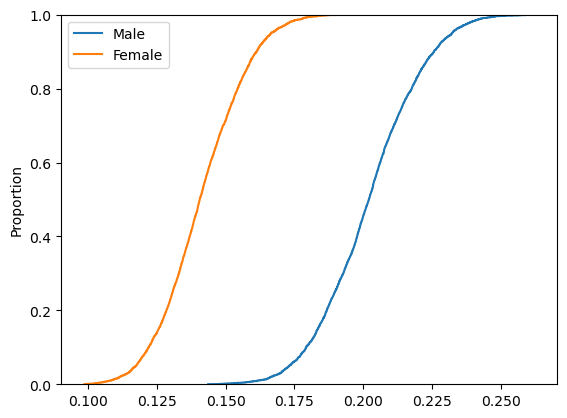

In [104]:
post_samples = idata.posterior.alpha.stack(draws=("chain", "draw")).values
prob_samples = expit(post_samples)
labels = np.array(["Male", "Female"])
fig, ax = plt.subplots()
for i in range(post_samples.shape[0]):
    sns.ecdfplot(
        prob_samples[i, :],
        label=f"{labels[i]}",
        ax=ax
    )
ax.legend()

## Direct Effect of Gender

In [105]:
with pm.Model(coords=coords) as direct_effect_test_m:
    
    alpha = pm.Normal("alpha", mu=0, sigma=1, dims=("gender", "department"))
    
    acc_prob = pm.Deterministic("acc_prob", var=pm.math.invlogit(alpha[G, D]))
    
    acc = pm.Bernoulli("acc", p=acc_prob, observed=A)
    
    idata_dir = pm.sample_prior_predictive()
    idata_dir.extend(pm.sample())

Sampling: [acc, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [106]:
az.summary(idata_dir.posterior, var_names=["alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[0, 0]",-0.708,0.141,-0.972,-0.447,0.002,0.001,6052.0,2973.0,1.0
"alpha[0, 1]",-2.192,0.198,-2.539,-1.807,0.002,0.002,6980.0,3245.0,1.0
"alpha[1, 0]",-1.187,0.159,-1.469,-0.880,0.002,0.002,5626.0,2757.0,1.0
"alpha[1, 1]",-2.541,0.224,-2.973,-2.153,0.003,0.002,5980.0,3054.0,1.0


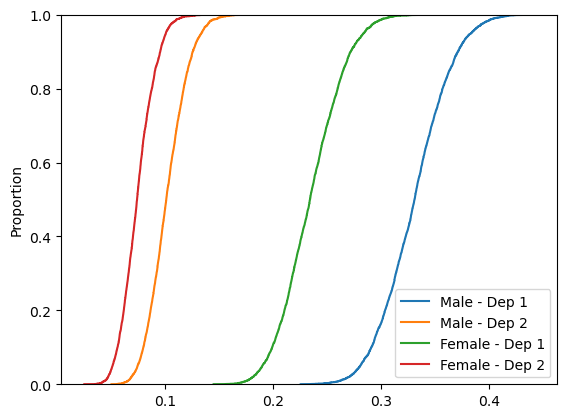

In [107]:
post_samples = idata_dir.posterior.alpha.stack(draws=("chain", "draw")).values
prob_samples = expit(post_samples)
labels = np.array([["Male", "Female"], ["Dep 1", "Dep 2"]])
fig, ax = plt.subplots()
for i in range(post_samples.shape[0]):
    for j in range(post_samples.shape[1]):
        sns.ecdfplot(
            prob_samples[i, j, :],
            label=f"{labels[0, i]} - {labels[1, j]}",
            ax=ax
        )
ax.legend()

# With the actual data 

In [108]:
df_ucb.head()

,dept,gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


## Total Effect

In [141]:
gender_codes, gens = pd.factorize(df_ucb["gender"])
dept_codes, depts = pd.factorize(df_ucb["dept"])
num_app = df_ucb["applications"]
acc = df_ucb["admit"]

In [142]:
coords = {
    "gender": gens,
    "department": depts
}

In [122]:
with pm.Model(coords=coords) as total_effect_m:
    alpha = pm.Normal("alpha", mu=0, sigma=1, dims="gender")
    
    acc_prob = pm.Deterministic("acc_prob", var=pm.math.invlogit(alpha[gender_codes]))
    
    acc = pm.Binomial("acc", n=num_app, p=acc_prob, observed=acc)
    
    idata_ind = pm.sample_prior_predictive()
    idata_ind.extend(pm.sample())

Sampling: [acc, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [123]:
az.summary(idata_ind.posterior, var_names=["alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[male],-0.221,0.038,-0.294,-0.152,0.001,0.000,3934.0,3165.0,1.0
alpha[female],-0.828,0.051,-0.924,-0.735,0.001,0.001,4007.0,2952.0,1.0


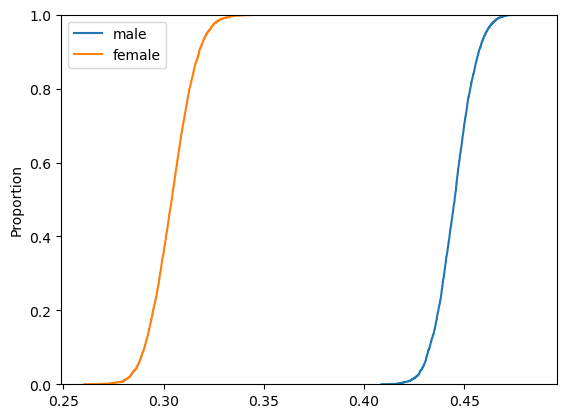

In [126]:
post_samples = idata_ind.posterior.alpha.stack(draws=("chain", "draw")).values
prob_samples = expit(post_samples)
fig, ax = plt.subplots()
for i in range(post_samples.shape[0]):
    sns.ecdfplot(
        prob_samples[i, :],
        label=f"{gens[i]}",
        ax=ax
    )
ax.legend()

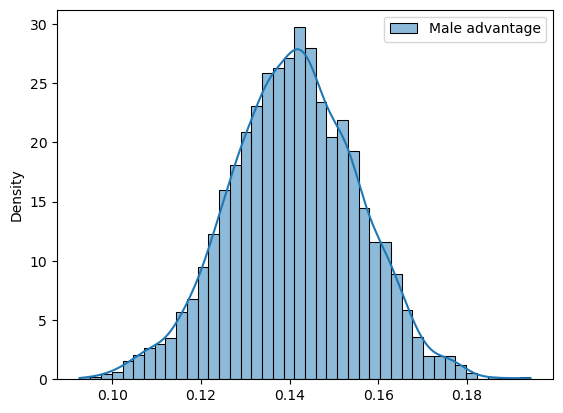

In [129]:
fig, ax = plt.subplots()
sns.histplot(
    prob_samples[0, :] - prob_samples[1, :],
    label=f"Male advantage",
    stat="density",
    kde=True,
    ax=ax
)
ax.legend()

## Direct effect

In [226]:
gender_codes, gens = pd.factorize(df_ucb["gender"])
dept_codes, depts = pd.factorize(df_ucb["dept"])
num_app = df_ucb["applications"].values
acc_obs = df_ucb["admit"].values

In [227]:
coords = {
    "gender": gens,
    "department": depts,
}

In [262]:
with pm.Model() as direct_effect_m:
    
    # direct_effect_m.add_coord("observation", np.arange(len(num_app)), mutable=True)
    G_obs = pm.MutableData("G_obs", gender_codes)
    D_obs = pm.MutableData("D_obs", dept_codes)
    N_obs = pm.MutableData("N_obs", num_app)
    
    alpha = pm.Normal("alpha", mu=0, sigma=1, shape=(len(gens), len(depts)))
    
    acc_prob = pm.Deterministic("acc_prob", var=pm.math.invlogit(alpha[G_obs, D_obs]))
    
    acc = pm.Binomial("acc", n=N_obs, p=acc_prob, observed=acc_obs)
    
    idata_dir = pm.sample_prior_predictive()
    idata_dir.extend(pm.sample())

Sampling: [acc, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [211]:
az.summary(idata_dir.posterior, var_names=["alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[male, A]",0.491,0.070,0.361,0.620,0.001,0.001,7301.0,3009.0,1.0
"alpha[male, B]",0.530,0.088,0.365,0.691,0.001,0.001,6069.0,3307.0,1.0
"alpha[male, C]",-0.531,0.115,-0.749,-0.319,0.001,0.001,7338.0,3329.0,1.0
"alpha[male, D]",-0.696,0.107,-0.890,-0.487,0.001,0.001,5505.0,2858.0,1.0
"alpha[male, E]",-0.939,0.163,-1.268,-0.648,0.002,0.002,6109.0,3161.0,1.0
"alpha[male, F]",-2.662,0.206,-3.060,-2.285,0.003,0.002,6005.0,3043.0,1.0
"alpha[female, A]",1.468,0.241,1.009,1.918,0.003,0.002,5733.0,3092.0,1.0
"alpha[female, B]",0.650,0.388,-0.083,1.377,0.005,0.004,6309.0,3142.0,1.0
"alpha[female, C]",-0.657,0.086,-0.812,-0.491,0.001,0.001,6674.0,3026.0,1.0
"alpha[female, D]",-0.615,0.109,-0.820,-0.415,0.001,0.001,5808.0,3144.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'acc_prob'}>,
        <Axes: title={'center': 'acc_prob'}>]], dtype=object)

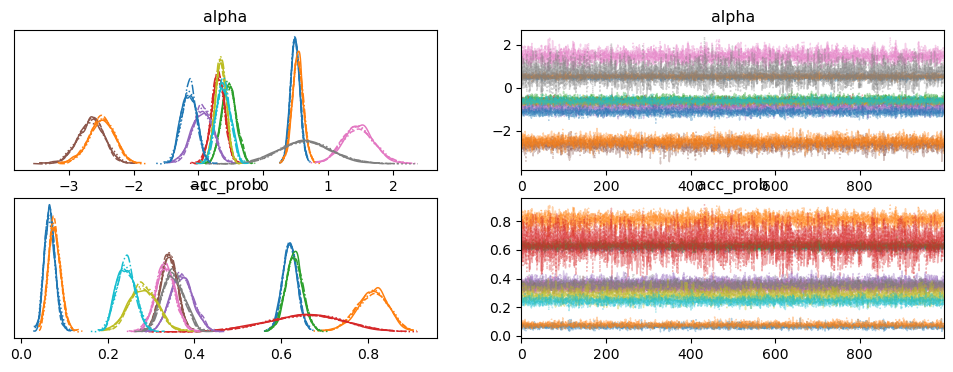

In [182]:
az.plot_trace(idata_dir)

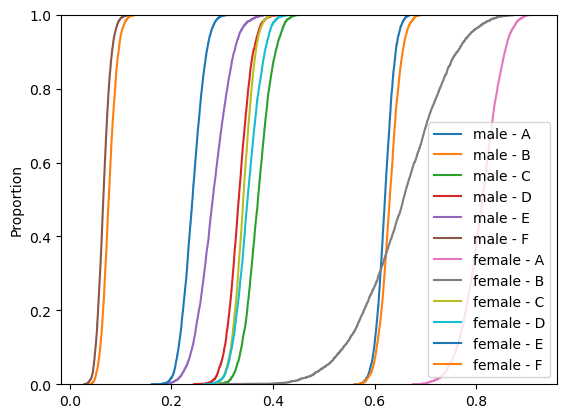

In [183]:
post_samples = idata_dir.posterior.alpha.stack(draws=("chain", "draw")).values
prob_samples = expit(post_samples)
fig, ax = plt.subplots()
for i in range(post_samples.shape[0]):
    for j in range(post_samples.shape[1]):
        sns.ecdfplot(
            prob_samples[i, j, :],
            label=f"{gens[i]} - {depts[j]}",
            ax=ax
        )
ax.legend()

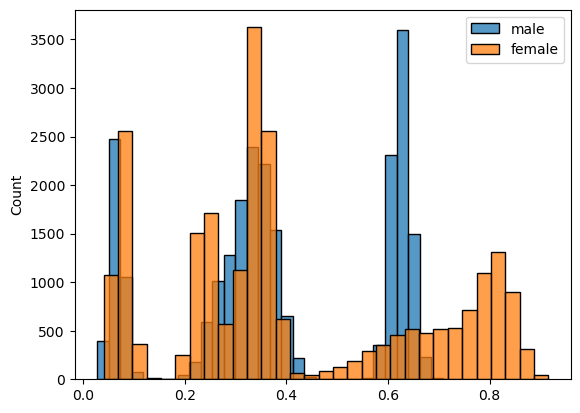

In [184]:
fig, ax = plt.subplots()
for i in range(post_samples.shape[0]):
    sns.histplot(
        prob_samples[i, :, :].flatten(),
        label=f"{gens[i]}",
        ax=ax
    )
ax.legend()

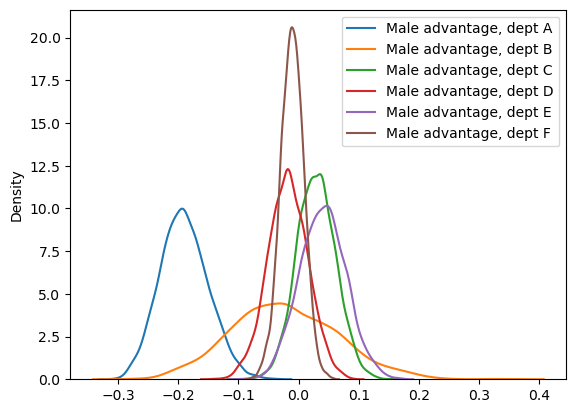

In [185]:
fig, ax = plt.subplots()
for j in range(post_samples.shape[1]):
    sns.kdeplot(
        prob_samples[0, j, :] - prob_samples[1, j, :],
        label=f"Male advantage, dept {depts[j]}",
        ax=ax
    )
ax.legend()

## Counterfactuals

In [230]:
total_apps = df_ucb["applications"].sum()
apps_per_dept = (
    df_ucb
    .groupby("dept", as_index=False)
    .agg(
        apps_per_dep=("applications", sum)
    )
)

### All men

In [231]:
G_men = np.zeros(shape=apps_per_dept["apps_per_dep"].sum(), dtype=int)
N_men = np.ones(shape=apps_per_dept["apps_per_dep"].sum(), dtype=int)
D_men = np.repeat(pd.factorize(apps_per_dept["dept"])[0], apps_per_dept["apps_per_dep"].values)

In [245]:
with direct_effect_m:
    direct_effect_m.set_data("G_obs", G_men)
    direct_effect_m.set_data("D_obs", D_men)
    direct_effect_m.set_data("N_obs", N_men)
    post_samples_men = pm.sample_posterior_predictive(idata_dir.posterior, return_inferencedata=False, var_names=["acc_prob"], )

Sampling: []


In [261]:
post_samples_men["acc_prob"]

array([[[0.60867605, 0.60867605, 0.60867605, ..., 0.06083673,
         0.06083673, 0.06083673],
        [0.65524534, 0.65524534, 0.65524534, ..., 0.04891806,
         0.04891806, 0.04891806],
        [0.58320113, 0.58320113, 0.58320113, ..., 0.08412876,
         0.08412876, 0.08412876],
        ...,
        [0.6336904 , 0.6336904 , 0.6336904 , ..., 0.07352612,
         0.07352612, 0.07352612],
        [0.64126365, 0.64126365, 0.64126365, ..., 0.08226993,
         0.08226993, 0.08226993],
        [0.59846995, 0.59846995, 0.59846995, ..., 0.0505064 ,
         0.0505064 , 0.0505064 ]],

       [[0.62221044, 0.62221044, 0.62221044, ..., 0.05814376,
         0.05814376, 0.05814376],
        [0.62221044, 0.62221044, 0.62221044, ..., 0.05814376,
         0.05814376, 0.05814376],
        [0.60568502, 0.60568502, 0.60568502, ..., 0.06938061,
         0.06938061, 0.06938061],
        ...,
        [0.58501479, 0.58501479, 0.58501479, ..., 0.04266781,
         0.04266781, 0.04266781],
        [0.5

### All women

In [247]:
G_women = np.ones(shape=apps_per_dept["apps_per_dep"].sum(), dtype=int)
N_women = np.ones(shape=apps_per_dept["apps_per_dep"].sum(), dtype=int)
D_women = np.repeat(pd.factorize(apps_per_dept["dept"])[0], apps_per_dept["apps_per_dep"].values)

In [248]:
with direct_effect_m:
    direct_effect_m.set_data("G_obs", G_women, coords={"observation": range(len(G_women))})
    direct_effect_m.set_data("D_obs", D_women, coords={"observation": range(len(D_women))})
    direct_effect_m.set_data("N_obs", N_women, coords={"observation": range(len(N_women))})
    post_samples_women = pm.sample_posterior_predictive(idata_dir.posterior, return_inferencedata=False, var_names=["acc_prob"])

Sampling: []


In [259]:
post_samples_men["acc_prob"].flatten().shape.

(18104000,)

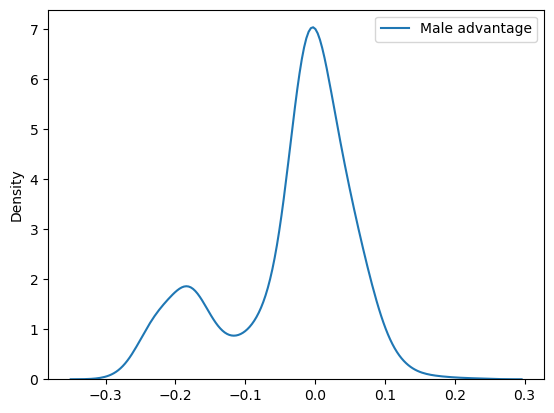

In [265]:
fig, ax = plt.subplots()
sns.kdeplot(
    np.random.choice((post_samples_men["acc_prob"].flatten() - post_samples_women["acc_prob"].flatten()), size=2000, replace=False), 
    label=f"Male advantage",
    ax=ax
)
ax.legend()

# Survival Analysis

In [268]:
df_cats = (
    pd.read_csv(DATA_PATH / "AustinCats.csv", sep=";")
)
    

In [269]:
df_cats.head()

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age
0,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7
1,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1
2,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2
3,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12
4,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1


In [270]:
df_cats["out_event"].unique()

array(['Transfer', 'Adoption', 'Euthanasia', 'Censored', 'Died',
       'Missing', 'Disposal'], dtype=object)